In [1]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU

In [2]:
# Load data
data = pd.read_csv('../data/stocks_clean.csv', index_col='Date', parse_dates=True)

In [3]:
# Normalise data

y = data['aapl_adj_close']
X = data.drop(columns=['aapl_adj_close'])

# Initialize the StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform the features (X)
X_scaled = scaler_X.fit_transform(X)

# Convert the scaled X back to a DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit and transform the target (y), needs to be reshaped as it's 1D
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Convert the scaled y back to a DataFrame to preserve column name
y_scaled = pd.DataFrame(y_scaled, columns=['aapl_adj_close'], index=y.index)

In [4]:
train_size = 0.8
ntrain = round(len(y) * 0.8)
ntest = len(y) - ntrain
X_train, X_test = X[:ntrain], X[ntrain:]
y_train, y_test = y[:ntrain], y[ntrain:]
print(f"Train size: {ntrain}, Test size: {ntest}")

Train size: 1416, Test size: 354


## Recurrent Neural Network Model #1 : Long Short-Term Memory (LSTM)

### Create sliding window sequences

In [5]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386,)


### Build and train LSTM model

In [6]:
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)  # Output layer for price prediction
])

model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2121816.7500 - val_loss: 1218084.8750
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 908301.3125 - val_loss: 3075483.7500
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2755196.0000 - val_loss: 166973.7188
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 583992.6875 - val_loss: 191375.6562
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 857846.8750 - val_loss: 65765.4141
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 427547.5938 - val_loss: 182518.7500
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1034852.6875 - val_loss: 67413.5547
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 509578.0312 - val_loss: 28049.8555
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 205961.0781 - val_loss: 6587.7441
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 168338.7500 - val_loss: 7346.4575


### Make predictions and evaluate performance

In [7]:
# LSTM Predictions and Evaluation
y_test_rescaled = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1))
y_pred_seq_lstm = model_lstm.predict(X_test_seq)
y_pred_lstm = scaler_y.inverse_transform(y_pred_seq_lstm)

# Calculate LSTM Metrics
rmse_lstm = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_lstm))
mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_rescaled, y_pred_lstm)

# Display LSTM Metrics
print(f"LSTM Model - RMSE: {rmse_lstm}, MAE: {mae_lstm}, MAPE: {mape_lstm}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
LSTM Model - RMSE: 4046.273360717349, MAE: 3297.433016377661, MAPE: 0.3050317908861545%


### Visualisation of results

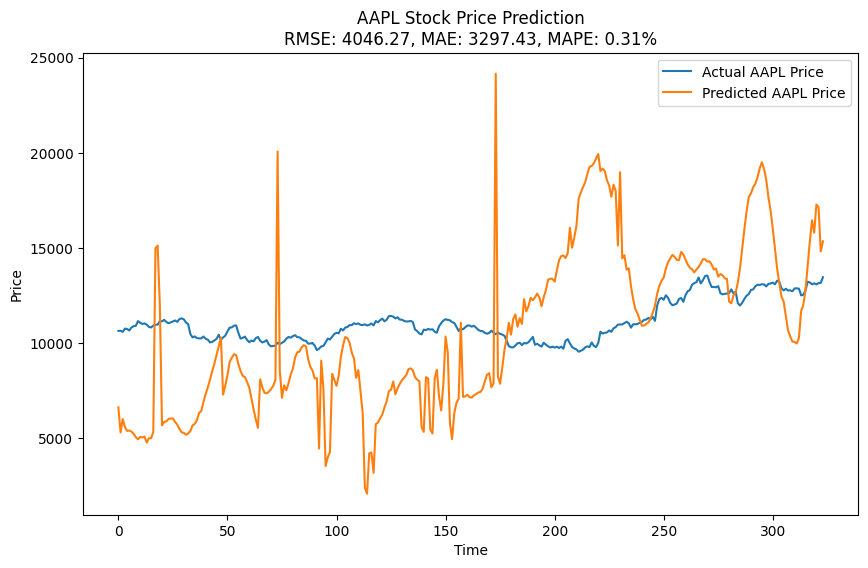

In [8]:
# Plot actual vs predicted prices with metrics in the title
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred_lstm, label='Predicted AAPL Price')
plt.title(f'AAPL Stock Price Prediction\nRMSE: {rmse_lstm:.2f}, MAE: {mae_lstm:.2f}, MAPE: {mape_lstm:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
# Store metrics for different models
results = pd.DataFrame({
    'Model': ['LSTM'],
    'RMSE': [rmse_lstm],
    'MAE': [mae_lstm],
    'MAPE (%)': [mape_lstm]
})

print(results)


  Model         RMSE          MAE  MAPE (%)
0  LSTM  4046.273361  3297.433016  0.305032


## Recurrent Neural Network Model #2 : GRU

### Create sliding window sequences

In [10]:
def create_sequences(X, y, n_steps):
    """
    Create sliding window sequences for RNN models.
    
    :param X: Feature DataFrame
    :param y: Target series
    :param n_steps: Number of timesteps for each input sequence
    :return: Arrays of input sequences (X_seq) and corresponding targets (y_seq)
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - n_steps):
        X_seq.append(X.iloc[i:i + n_steps].values)
        y_seq.append(y.iloc[i + n_steps])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (e.g., last 30 days to predict next day)
n_steps = 30

# Create sequences for train and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, n_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, n_steps)

print(f"Training sequences shape: {X_train_seq.shape}, Target shape: {y_train_seq.shape}")

Training sequences shape: (1386, 30, 9), Target shape: (1386,)


### Build and train GRU model

In [11]:
# Define GRU model
model_gru = Sequential([
    GRU(64, activation='relu', input_shape=(n_steps, X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mean_squared_error')
history_gru = model_gru.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 10725.4707 - val_loss: 842.3774
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4367.2549 - val_loss: 940.5010
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2554.6648 - val_loss: 447.9151
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1569.8655 - val_loss: 409.9313
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 986.9977 - val_loss: 873.3533
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 679.6550 - val_loss: 619.4201
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 614.3299 - val_loss: 429.0092
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 490.9401 - val_loss: 493.3421
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 515.5563 - val_loss: 452.2202
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 426.1864 - val_loss: 451.2798


### Make predictions and evaluate performance

In [12]:
# GRU Predictions and Evaluation
y_pred_seq_gru = model_gru.predict(X_test_seq)
y_pred_gru = scaler_y.inverse_transform(y_pred_seq_gru)

# Calculate GRU Metrics
rmse_gru = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_gru))
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mape_gru = mean_absolute_percentage_error(y_test_rescaled, y_pred_gru)

# Display GRU Metrics
print(f"GRU Model - RMSE: {rmse_gru}, MAE: {mae_gru}, MAPE: {mape_gru}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
GRU Model - RMSE: 2640.5285370480974, MAE: 2556.9318322501094, MAPE: 0.22778158434245602%


### Visualise results

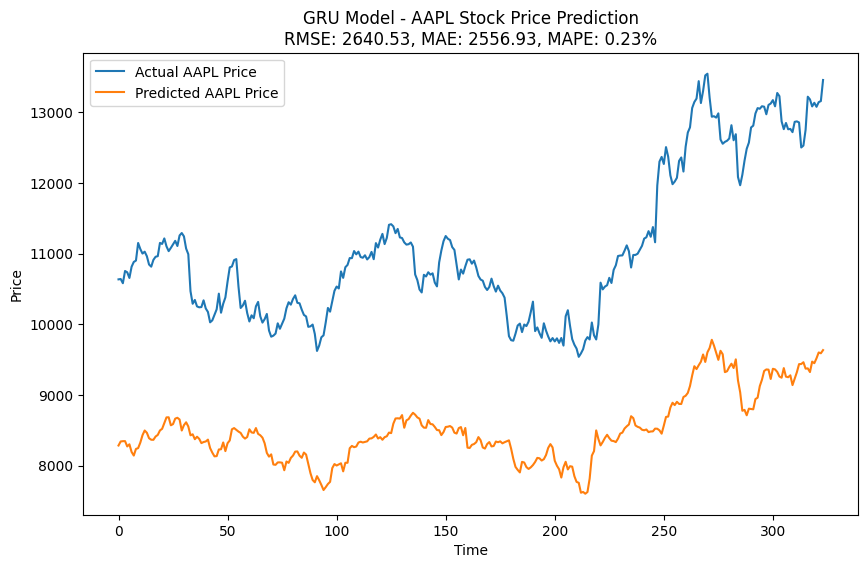

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual AAPL Price')
plt.plot(y_pred_gru, label='Predicted AAPL Price')
plt.title(f'GRU Model - AAPL Stock Price Prediction\nRMSE: {rmse_gru:.2f}, MAE: {mae_gru:.2f}, MAPE: {mape_gru:.2f}%')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


## Comparison of results of Model #1: LSTM and Model #2: GRU

In [14]:
# Store metrics for LSTM and GRU
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [rmse_lstm, rmse_gru],
    'MAE': [mae_lstm, mae_gru],
    'MAPE (%)': [mape_lstm, mape_gru]
})

print(results)


  Model         RMSE          MAE  MAPE (%)
0  LSTM  4046.273361  3297.433016  0.305032
1   GRU  2640.528537  2556.931832  0.227782


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim

def grid_search_rnn_models(x_train, y_train, x_test, y_test, param_grid, num_epochs=10, batch_size=32):
    best_score, best_model_type, best_params = float("inf"), None, None
    
    # Convert DataFrames to PyTorch tensors
    x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    for model_type in ["GRU", "LSTM"]:
        for params in param_grid:
            n_layers = params['n_layers']
            hidden_size = params['hidden_size']
            learning_rate = params['learning_rate']

            # Define model based on type (GRU or LSTM)
            model = (nn.GRU if model_type == "GRU" else nn.LSTM)(
                input_size=1, hidden_size=hidden_size, num_layers=n_layers, batch_first=True
            )

            # Define loss function and optimizer
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

            # Training loop
            model.train()
            num_samples = len(x_train_tensor)
            for epoch in range(num_epochs):
                for i in range(0, num_samples, batch_size):
                    inputs = x_train_tensor[i:i + batch_size].unsqueeze(2)  # Add feature dimension
                    targets = y_train_tensor[i:i + batch_size].view(-1, 1)  # Reshape targets

                    optimizer.zero_grad()  # Clear gradients
                    outputs, _ = model(inputs)  # Get model outputs

                    loss = criterion(outputs[:, -1, :], targets)  # Compare to actual targets
                    loss.backward()  # Backpropagation
                    optimizer.step()  # Update model parameters
            
            # Evaluation loop
            model.eval()
            with torch.no_grad():
                outputs, _ = model(x_test_tensor.unsqueeze(2))  # Ensure test data has the right shape
                rmse = torch.sqrt(criterion(outputs[:, -1, :], y_test_tensor.view(-1, 1)))  # Calculate RMSE
            
            # Update the best model if the current RMSE is lower
            if rmse.item() < best_score:
                best_score, best_model_type, best_params = rmse.item(), model_type, params

            print(f'{model_type} with params={params} RMSE={rmse.item()}')

    print(f'Best model: {best_model_type} with params={best_params} and RMSE={best_score}')
    return best_model_type, best_params, best_score

# Example usage
# x_train, y_train, x_test, y_test should be pre-defined pandas DataFrames
param_grid = [
    {'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001},
    {'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01}
]

# Call the grid search function
best_model_type, best_params, best_score = grid_search_rnn_models(X_train, y_train, X_test, y_test, param_grid)


GRU with params={'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001} RMSE=189.87901306152344
GRU with params={'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01} RMSE=189.8789520263672
LSTM with params={'n_layers': 1, 'hidden_size': 32, 'learning_rate': 0.001} RMSE=190.0971221923828
LSTM with params={'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01} RMSE=189.8789520263672
Best model: GRU with params={'n_layers': 2, 'hidden_size': 64, 'learning_rate': 0.01} and RMSE=189.8789520263672
